# This notebook will be mainly used for the capstone project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
import seaborn as sns
from sklearn.utils import resample
%matplotlib inline
print("Hello Capstone Project Course")

Hello Capstone Project Course


# Introduction: Business Problem and Background
Seattle being one of the fastest-growing major United States cities has recently been experiencing an increase in the number of road accidents. As such, this had caught an attention in key stakeholders within the Seattle Department of Transport (SDOT). Noting the City’s long-term vision of making Seattle one of the most liveable cities in the world, the SDOT want detailed insights on the car accident severity (fatality) considering key factors that might have contributed to the accident.  The findings will be very useful as they will enable stakeholders to deduce data-driven strategies to prevent future road accidents and thus, consequently saving lives.

# Description of the Data
To solve this problem, the readily available shared “data-collision” dataset from SDOT will be used. The dataset has 38 attributes (columns), with the first column being the target column labelled “SEVERITYCODE”. The remaining 37 attributes are feature candidates to choose from when building the model. In total, the dataset contains 194 673 observations which are sufficient to train and test the machine learning model. The 37 attributes comprise categorial and numerical data. Key consideration will be taken when selecting feature columns, for instance, columns with very high numbers of missing values or are duplicates will be dropped e.g., SPEEDING (9333 non-null entries), EXCEPTRSNDESC (5638 non-null entries), PEDROWNOTGRNT (4667 non-null entries) and a duplicate column of SEVERITYCODE. On the other hand, feature columns including but not limited to weather condition (WEATHER), light conditions (LIGHTCOND), road condition (ROADCOND) junction type (JUNCTIONTYPE), number of people involved (PERSONCOUNT), number of vehicles involved (VEHCOUNT), and collision type (COLLISIONTYPE) will be viable candidates to consider when building the model. It is also worth noting that these columns have non-null values > 189 000. Finally, it is worth noting that the target label is very unbalanced ~ 7:3, hence the dataset needs to be balanced to avoid the effects of bias in the model.

## Description of important attributes considered for model building 
| Attribute | Description|
| --------- | -----------|
| WEATHER | Weather conditions
| ROADCOND | Road conditions
| LIGHTCOND | Light conditions
| UNDERINFL | Influence of drugs or alcohol status
| JUNCTIONTYPE | Category of junction
| VEHCOUNT | Number of vehicles involved
| COLLISIONTYPE | Collision type
| PERSONCOUNT | Total number of people involved
| INCDTTM | Date and time of the incident
| SEVERITYCODE | Severity code of the collision (1-property damage, 2-injury)

### Methodology
In this section, we present the methodology adopted in addressing the business problem utilizing the provided datasets from SDOT. In particular, we analyse the dataset to summarize the main characteristics. We perform descriptive statistical analysis to describe our data using e.g., describe(), value_counts(), and info() methods. This allows us to gain more insights about the nature of the data including types, missing data, and whether target classes are balanced or not (to avoid biased model). We then pre-process the selected features including:
- Converting date and time to datetime object.
- Dropping missing data since they were very few relative to the entire dataset.
- Handling imbalanced classes by considering different techniques including 1) up-sample minority class, 2) down-sample majority class, 3) penalize algorithms and 4) tree-based algorithms. In this work, we adopted the down-sample approach since we had a very large dataset.
- Handling categorial variables with many levels. We used a two-step approach of 1) combining levels (to filter out rare levels) using frequency distribution i.e., we examined frequency distribution of each level and combined levels having frequency less than 5% of total observation (this threshold is standard and can be changed based on the distribution) and 2) dummy coding the resulting categorial variables.
- Data visualization of the resulting dataframe to examine the severity of the accidents at e.g., a particular day of the week considering a wide range of selected features (weather conditions, road conditions, light conditions, junction type).

Finally, after data pre-processing stage, we used machine learning approaches to build a model that predicts (with the best accuracy) the accident severity and applied the following classification algorithms; Support Vector Machine (SVM), Decision Tree, K Nearest Neighbor (KNN), and Logistic Regression. 

In [2]:
#features = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'UNDERINFL', 'JUNCTIONTYPE', 'VEHCOUNT', 'COLLISIONTYPE', 'PERSONCOUNT', 'INCDATE','INCDTTM']
features = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'JUNCTIONTYPE', 'VEHCOUNT','INCDTTM']

In [42]:
# clean up the dataset to remove uncessary columns
# feature selection: dataframe
df = pd.read_csv("Data-Collisions.csv")
warnings.filterwarnings('ignore')

# Reserve 1000 rows for unseen test data and remaining for train data
df_test = df[0:1000]
df_train = df[1000:11000] # reducing training dataset size
df_test.to_csv("Data-Collisions_test.csv") #unseen test set file
df_train.to_csv("Data-Collisions_train.csv") # training set file


In [4]:
# Reading training dataset
df_train = pd.read_csv("Data-Collisions_train.csv")
y=df_train['SEVERITYCODE']
df_train=df_train[features]
df_train['SEVERITYCODE'] = y
df_train.head()

,WEATHER,ROADCOND,LIGHTCOND,JUNCTIONTYPE,VEHCOUNT,INCDTTM,SEVERITYCODE
0,Clear,Dry,Dark - Street Lights On,Mid-Block (not related to intersection),1,11/21/2007 9:58:00 PM,2
1,Unknown,Unknown,Daylight,Mid-Block (not related to intersection),2,8/13/2004 8:00:00 PM,1
2,Clear,Dry,Daylight,Mid-Block (not related to intersection),2,5/14/2006 10:30:00 AM,1
3,Clear,Dry,Daylight,Mid-Block (not related to intersection),3,3/28/2013 4:30:00 PM,1
4,Unknown,Unknown,Unknown,Mid-Block (not related to intersection),2,6/13/2005 7:10:00 AM,1


In [5]:
# convert to date time object
#df['INCDATE'] = pd.to_datetime(df.INCDATE, errors='coerce') #errors='coerce' to handle non-sensical date data.
df_train['INCDTTM'] = pd.to_datetime(df_train['INCDTTM'])
df_train['DATE'] = df_train['INCDTTM'].dt.date # adding date only column
df_train['TIME'] = df_train['INCDTTM'].dt.time # adding time only column
df_train['DAYofWEEK'] =  pd.to_datetime(df_train['DATE']).dt.dayofweek # gets day of the week using df.dt.dayofweek
df_train['WEEKEND'] = df_train['DAYofWEEK'].apply(lambda x: 1 if (x>3)  else 0)


In [6]:
# Identifying, Dropping NaNs or Missing values 
# Dropping Missing Values and reset the index:
#print(df.shape)
df_train.dropna(inplace = True)
df_train.reset_index(drop = True, inplace = True)
print(df_train.shape) 
#df.isnull().sum() # check to see how many null objects

(9806, 11)


In [7]:
# Descriptive Statistical Analysis
df_train.describe(include=['object']) # object
df_train.describe() # numerical
df_train.info() # types

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9806 entries, 0 to 9805
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   WEATHER       9806 non-null   object        
 1   ROADCOND      9806 non-null   object        
 2   LIGHTCOND     9806 non-null   object        
 3   JUNCTIONTYPE  9806 non-null   object        
 4   VEHCOUNT      9806 non-null   int64         
 5   INCDTTM       9806 non-null   datetime64[ns]
 6   SEVERITYCODE  9806 non-null   int64         
 7   DATE          9806 non-null   object        
 8   TIME          9806 non-null   object        
 9   DAYofWEEK     9806 non-null   int64         
 10  WEEKEND       9806 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(6)
memory usage: 842.8+ KB


In [8]:
# Checking for imbalanced classes: to avoid bias in the model
y_classes = df_train['SEVERITYCODE'] 
#y_classes.value_counts() # class 1 is majority and class 2 is minority
df_majority = df_train[df_train.SEVERITYCODE==1]
df_minority = df_train[df_train.SEVERITYCODE==2]

# Technique 1: Downsample majority class: to match minority class
df_majority_downsampled = resample(df_majority, 
                                replace=False,    # sample without replacement
                               n_samples=df_minority.shape[0],     
                               random_state=4) # reproducible results

# Concatenate minority class with downsampled majority class
df_downsampled = pd.concat([df_majority_downsampled, df_minority])

# Show new class counts
df_downsampled.SEVERITYCODE.value_counts()

# Reset index
df_downsampled.reset_index(drop=True, inplace = True)
df_downsampled.head()

,WEATHER,ROADCOND,LIGHTCOND,JUNCTIONTYPE,VEHCOUNT,INCDTTM,SEVERITYCODE,DATE,TIME,DAYofWEEK,WEEKEND
0,Clear,Unknown,Unknown,Mid-Block (not related to intersection),2,2004-01-25 12:00:00,1,2004-01-25,12:00:00,6,1
1,Clear,Dry,Daylight,Driveway Junction,2,2004-09-17 15:17:00,1,2004-09-17,15:17:00,4,1
2,Unknown,Unknown,Unknown,Mid-Block (not related to intersection),2,2004-11-19 00:01:00,1,2004-11-19,00:01:00,4,1
3,Clear,Dry,Daylight,At Intersection (but not related to intersection),2,2004-06-04 00:00:00,1,2004-06-04,00:00:00,4,1
4,Other,Unknown,Dark - Street Lights On,Mid-Block (not related to intersection),2,2004-02-02 00:00:00,1,2004-02-02,00:00:00,0,0


In [9]:
# Function: combine levels using frequency distribution less than 5%
# x: attribute (column of interest) -> string, df_downsample is the dataframe
def combine_levels(df_downsampled, x, freq_thresh):
    df_col = df_downsampled[x].values.tolist() # column of interest
    df_freq = df_downsampled[x].value_counts(normalize = True) * 100
    df_freq_index = []
    for index in range(len(df_freq)):
        if df_freq[index] <= freq_thresh:
            df_freq_index.append(index)
    return df_freq_index
            

In [10]:
# Handling categorial variables: combine-many-levels and then apply dummy-coding: Frequecny distribution approach
x=['WEATHER', 'ROADCOND', 'LIGHTCOND', 'JUNCTIONTYPE','VEHCOUNT'] # variable to combine
freq_thresh = 5
# Lets first convert VEHCOUNT column to string: to access index as strings instead of int
df_downsampled.VEHCOUNT = df_downsampled.VEHCOUNT.astype('str')
# for loop to combine levels for different columns
for i in range(len(x)):
    df_x_freq = df_downsampled[x[i]].value_counts(normalize = True) * 100
    df_freq_index = combine_levels(df_downsampled, x[i], freq_thresh) # calling function to get indices
    df_x_freq_to_df = df_x_freq.to_frame() # converting to dataframe
    f_index = df_x_freq_to_df.index.tolist() # getting the indice (names) as lists
    replace_levels = f_index[min(df_freq_index):max(df_freq_index)+1] # levels to be replaced
    df_downsampled[x[i]].replace(to_replace=replace_levels, value='Other',inplace=True) # replacing less frequent levels with one category
    #df[x[i]].value_counts(normalize = True)


In [11]:
#Selected Features before One Hot Encoding
selected_features = ['WEATHER', 'ROADCOND', 'LIGHTCOND', 'JUNCTIONTYPE','VEHCOUNT', 'DAYofWEEK', 'WEEKEND']
df_downsampled[selected_features].head()


,WEATHER,ROADCOND,LIGHTCOND,JUNCTIONTYPE,VEHCOUNT,DAYofWEEK,WEEKEND
0,Clear,Other,Other,Mid-Block (not related to intersection),2,6,1
1,Clear,Dry,Daylight,Driveway Junction,2,4,1
2,Other,Other,Other,Mid-Block (not related to intersection),2,4,1
3,Clear,Dry,Daylight,Other,2,4,1
4,Other,Other,Dark - Street Lights On,Mid-Block (not related to intersection),2,0,0


In [12]:
# One hot encoding to convert categorial variables to binary variables and append them to the feature dataframe
df_selected_features = df_downsampled[selected_features]
df_selected_features = pd.concat([df_selected_features,pd.get_dummies(df_downsampled[x])], axis=1)
df_selected_features.drop(x, axis = 1,inplace=True)
df_selected_features.head()
#df_can.rename(columns={'OdName':'Country', 'AreaName':'Continent', 'RegName':'Region'}, inplace=True)

,DAYofWEEK,WEEKEND,WEATHER_Clear,WEATHER_Other,WEATHER_Overcast,WEATHER_Raining,ROADCOND_Dry,ROADCOND_Other,ROADCOND_Wet,LIGHTCOND_Dark - Street Lights On,...,LIGHTCOND_Other,JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Other,VEHCOUNT_1,VEHCOUNT_2,VEHCOUNT_3,VEHCOUNT_Other
0,6,1,1,0,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
1,4,1,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,4,1,0,1,0,0,0,1,0,0,...,1,0,0,0,1,0,0,1,0,0
3,4,1,1,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
4,0,0,0,1,0,0,0,1,0,1,...,0,0,0,0,1,0,0,1,0,0


In [13]:
# Renaming some columns to improve readability
df_selected_features.rename(columns={'LIGHTCOND_Dark - Street Lights On':'LIGHTCOND_Dark_SLO', 
                                     'JUNCTIONTYPE_At Intersection (intersection related)':'JUNCTIONTYPE_INT', 
                                     'JUNCTIONTYPE_Driveway Junction':'JUNCTIONTYPE_DJ',
                                    'JUNCTIONTYPE_Mid-Block (but intersection related)': 'JUNCTIONTYPE_MB_INT',
                                    'JUNCTIONTYPE_Mid-Block (not related to intersection)':'JUNCTIONTYPE_MB'}, inplace=True)

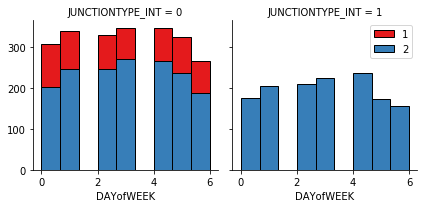

In [14]:
# Lets look at the severity of the accidents at a particular day of the week
df_clean = pd.concat([df_selected_features,df_downsampled['SEVERITYCODE']], axis=1) # cleaned data
bins = np.linspace(df_clean.DAYofWEEK.min(), df_clean.DAYofWEEK.max(), 10)
g = sns.FacetGrid(df_clean, col = 'JUNCTIONTYPE_INT', hue="SEVERITYCODE", palette="Set1",col_wrap=2)
g.map(plt.hist, 'DAYofWEEK', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

In [15]:
df_clean.columns

Index(['DAYofWEEK', 'WEEKEND', 'WEATHER_Clear', 'WEATHER_Other',
       'WEATHER_Overcast', 'WEATHER_Raining', 'ROADCOND_Dry', 'ROADCOND_Other',
       'ROADCOND_Wet', 'LIGHTCOND_Dark_SLO', 'LIGHTCOND_Daylight',
       'LIGHTCOND_Other', 'JUNCTIONTYPE_INT', 'JUNCTIONTYPE_DJ',
       'JUNCTIONTYPE_MB_INT', 'JUNCTIONTYPE_MB', 'JUNCTIONTYPE_Other',
       'VEHCOUNT_1', 'VEHCOUNT_2', 'VEHCOUNT_3', 'VEHCOUNT_Other',
       'SEVERITYCODE'],
      dtype='object')

In [16]:
#Set X (features) and y (target) data: Normalize X data - drop DAYofWEEK to remove dependency in the independent variables
X = df_clean.drop(['DAYofWEEK','SEVERITYCODE'], axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
y = df_clean['SEVERITYCODE']

## Classification
Now, we split the dataset into training set and test set to build the model with the best accuracy. We apply the following the algorithms:
- Support Vector Machine (SVM)
- Decision Tree
- K Nearest Neighbor (KNN)
- Logistic Regression

For accuracy evaluation, we consider Jaccard and Log-loss (where applicable) evaluation scoring metrics.

In [17]:
# Train Test Split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (4857, 20) (4857,)
Test set: (1215, 20) (1215,)


### Support Vector Machine

In [18]:
# Classification: Importing the classifier and Accuracy Scoring Metrics
from sklearn import svm
from sklearn.metrics import jaccard_similarity_score as jss
from sklearn.metrics import log_loss as lgl

In [19]:
# Classification: Train and Predicting: We simply use radial basis function (rbf) kernel
rbf_clf = svm.SVC(kernel='rbf', gamma='scale', probability=True)

# Train (Fit) the model
rbf_clf.fit(X_train, y_train) 

# Prediction
yhat_rbf = rbf_clf.predict(X_test)
yhat_prob_rbf = rbf_clf.predict_proba(X_test)

In [20]:
# Classification: Accuracy evaluation
num_dec=4 # Number of decimal points
svm_eval_acc_jss = jss(y_test, yhat_rbf).round(num_dec)
svm_eval_acc_lgl = lgl(y_test, yhat_prob_rbf).round(num_dec)

In [21]:
print("Jaccard:", svm_eval_acc_jss)
print("Log-loss:", svm_eval_acc_lgl )

Jaccard: 0.6305
Log-loss: 0.6504


### Decision Tree

In [22]:
# Classification: Importing the classifier 
from sklearn.tree import DecisionTreeClassifier

In [23]:
# Classifier
severityTree = DecisionTreeClassifier(criterion="entropy", max_depth = 4)

# Train (Fit) the model
severityTree.fit(X_train,y_train)

# Prediction
predTree = severityTree.predict(X_test)

In [24]:
# Classification: Accuracy evaluation
dt_eval_acc_jss = jss(y_test, predTree).round(num_dec)

In [25]:
print("Jaccard:", dt_eval_acc_jss)

Jaccard: 0.628


### K Nearest Neighbor (KNN)

In [26]:
# Classification: Importing the classifier
from sklearn.neighbors import KNeighborsClassifier

In [27]:
# Calculate accuracy for different Ks and finding the best K
Ks = 10
num_dec = 4; # number of decimals
knn_eval_acc_jss = np.zeros((Ks-1)) # to store evaluation accuracy using Jaccard index
for n in range(1,Ks):
    
    #Train Model and Predict  
    k_neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=k_neigh.predict(X_test)
    knn_eval_acc_jss[n-1] = jss(y_test, yhat)

knn_best_jss = knn_eval_acc_jss.max().round(num_dec)
print( "The best accuracy with Jaccard score of", knn_best_jss, "with k=", knn_eval_acc_jss.argmax()+1) # using argmax

# Building model using the best k
k_neigh = KNeighborsClassifier(n_neighbors = knn_eval_acc_jss.argmax()+1).fit(X_train,y_train)

The best accuracy with Jaccard score of 0.6099 with k= 5


### Logistic Regression

In [28]:
# Classification: Importing the classifier
from sklearn.linear_model import LogisticRegression

In [29]:
# Training (Fit) the model 
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)

# Prediction
yhat_LR = LR.predict(X_test)
yhat_prob_LR = LR.predict_proba(X_test)

In [30]:
# Classification: Accuracy evaluation
lr_eval_acc_jss = jss(y_test, yhat_LR).round(num_dec)
lr_eval_acc_lgl = lgl(y_test, yhat_prob_LR).round(num_dec)


In [31]:
print("Jaccard:", lr_eval_acc_jss)
print("Log-loss:", lr_eval_acc_lgl)

Jaccard: 0.6395
Log-loss: 0.6247


### Model Evaluation using Unseen Test Data

In [32]:
# Loading test data
df_test = pd.read_csv("Data-Collisions_test.csv")

In [33]:
# Feature selection and Pre-processing (handling missing data)
test_y=df_test['SEVERITYCODE']
df_test=df_test[features]
df_test['SEVERITYCODE'] = test_y
# convert to date time object
df_test['INCDTTM'] = pd.to_datetime(df_test['INCDTTM'])
df_test['DATE'] = df_test['INCDTTM'].dt.date # adding date only column
df_test['TIME'] = df_test['INCDTTM'].dt.time # adding time only column
df_test['DAYofWEEK'] =  pd.to_datetime(df_test['DATE']).dt.dayofweek # gets day of the week using df.dt.dayofweek
df_test['WEEKEND'] = df_test['DAYofWEEK'].apply(lambda x: 1 if (x>3)  else 0)

# Identifying, Dropping NaNs or Missing values and reset the index:
df_test.dropna(inplace = True)
df_test.reset_index(drop = True, inplace = True)
print(df_test.shape)

(926, 11)


In [34]:
# Handling categorial variables: combine-many-levels and then apply dummy-coding: Frequecny distribution approach
# Lets first convert VEHCOUNT column to string: to access index as strings instead of int
df_test.VEHCOUNT = df_test.VEHCOUNT.astype('str')
# for loop to combine levels for different columns
for i in range(len(x)):
    df_x_freq = df_test[x[i]].value_counts(normalize = True) * 100
    df_freq_index = combine_levels(df_test, x[i], freq_thresh) # calling function to get indices
    df_x_freq_to_df = df_x_freq.to_frame() # converting to dataframe
    f_index = df_x_freq_to_df.index.tolist() # getting the indice (names) as lists
    replace_levels = f_index[min(df_freq_index):max(df_freq_index)+1] # levels to be replaced
    df_test[x[i]].replace(to_replace=replace_levels, value='Other',inplace=True) # replacing less frequent levels

In [35]:
# One hot encoding to convert categorial variables to binary variables and append them to the feature dataframe
test_df_selected_features = df_test[selected_features]
test_df_selected_features = pd.concat([test_df_selected_features,pd.get_dummies(df_test[x])], axis=1)
test_df_selected_features.drop(x, axis = 1,inplace=True)
test_df_selected_features.head()

,DAYofWEEK,WEEKEND,WEATHER_Clear,WEATHER_Other,WEATHER_Overcast,WEATHER_Raining,WEATHER_Unknown,ROADCOND_Dry,ROADCOND_Other,ROADCOND_Unknown,...,LIGHTCOND_Other,JUNCTIONTYPE_At Intersection (intersection related),JUNCTIONTYPE_Driveway Junction,JUNCTIONTYPE_Mid-Block (but intersection related),JUNCTIONTYPE_Mid-Block (not related to intersection),JUNCTIONTYPE_Other,VEHCOUNT_1,VEHCOUNT_2,VEHCOUNT_3,VEHCOUNT_Other
0,2,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,2,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
2,3,0,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
3,4,1,1,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0
4,2,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0


In [36]:
# Renaming some columns to improve readability
test_df_selected_features.rename(columns={'LIGHTCOND_Dark - Street Lights On':'LIGHTCOND_Dark_SLO', 
                                     'JUNCTIONTYPE_At Intersection (intersection related)':'JUNCTIONTYPE_INT', 
                                     'JUNCTIONTYPE_Driveway Junction':'JUNCTIONTYPE_DJ',
                                    'JUNCTIONTYPE_Mid-Block (but intersection related)': 'JUNCTIONTYPE_MB_INT',
                                    'JUNCTIONTYPE_Mid-Block (not related to intersection)':'JUNCTIONTYPE_MB'}, inplace=True)

In [37]:
df_clean.columns

Index(['DAYofWEEK', 'WEEKEND', 'WEATHER_Clear', 'WEATHER_Other',
       'WEATHER_Overcast', 'WEATHER_Raining', 'ROADCOND_Dry', 'ROADCOND_Other',
       'ROADCOND_Wet', 'LIGHTCOND_Dark_SLO', 'LIGHTCOND_Daylight',
       'LIGHTCOND_Other', 'JUNCTIONTYPE_INT', 'JUNCTIONTYPE_DJ',
       'JUNCTIONTYPE_MB_INT', 'JUNCTIONTYPE_MB', 'JUNCTIONTYPE_Other',
       'VEHCOUNT_1', 'VEHCOUNT_2', 'VEHCOUNT_3', 'VEHCOUNT_Other',
       'SEVERITYCODE'],
      dtype='object')

In [38]:
test_df_selected_features.columns

Index(['DAYofWEEK', 'WEEKEND', 'WEATHER_Clear', 'WEATHER_Other',
       'WEATHER_Overcast', 'WEATHER_Raining', 'WEATHER_Unknown',
       'ROADCOND_Dry', 'ROADCOND_Other', 'ROADCOND_Unknown', 'ROADCOND_Wet',
       'LIGHTCOND_Dark_SLO', 'LIGHTCOND_Daylight', 'LIGHTCOND_Other',
       'JUNCTIONTYPE_INT', 'JUNCTIONTYPE_DJ', 'JUNCTIONTYPE_MB_INT',
       'JUNCTIONTYPE_MB', 'JUNCTIONTYPE_Other', 'VEHCOUNT_1', 'VEHCOUNT_2',
       'VEHCOUNT_3', 'VEHCOUNT_Other'],
      dtype='object')

In [39]:
#Set X (features) and y (target) data: Normalize X data - drop DAYofWEEK to remove dependency in the independent variables
test_y = df_test['SEVERITYCODE']
test_X = test_df_selected_features.drop(['DAYofWEEK','WEATHER_Unknown','ROADCOND_Unknown'], axis=1)
test_X = preprocessing.StandardScaler().fit(test_X).transform(test_X.astype(float))
test_X.shape
test_y.shape

(926,)

In [40]:
# Evaluation using unseen test set: use the X_test (to predict and get yhat_test) and y_test (to evaluate accuracy) 

# SVM
test_yhat_rbf = rbf_clf.predict(test_X)
test_yhat_prob_svm = rbf_clf.predict_proba(test_X)
svm_eval_jss= jss(test_y, test_yhat_rbf).round(num_dec)
svm_eval_lgl = lgl(test_y, test_yhat_prob_svm).round(num_dec)
print("SVM Jaccard:", svm_eval_jss)
print("SVM Log-loss:", svm_eval_lgl)

# Decision Tree
test_predTree = severityTree.predict(test_X)
dt_eval_jss= jss(test_y, test_predTree).round(num_dec)
print("DT Jaccard:", dt_eval_jss)


# K-Nearest Neighbour
test_yhat=k_neigh.predict(test_X)
knn_eval_jss= jss(test_y, test_yhat).round(num_dec)
print("KNN Jaccard:", knn_eval_jss)


# Logistic Regression
test_yhat_LR = LR.predict(test_X)
test_yhat_prob = LR.predict_proba(test_X)
ll_eval_jss= jss(test_y, test_yhat_LR).round(num_dec)
ll_eval_lgl = lgl(test_y, test_yhat_prob).round(num_dec)
print("LL Jaccard:", ll_eval_jss)
print("LL Logloss-Score:", ll_eval_lgl)

SVM Jaccard: 0.6037
SVM Log-loss: 0.658
DT Jaccard: 0.6058
KNN Jaccard: 0.5832
LL Jaccard: 0.6188
LL Logloss-Score: 0.6397


### Summary: Algorithms and Evaluation Metrics

In [41]:
# Reporting using pandas dataframe
data = {'Algorithm':['SVM','Decision Tree','KNN','Logistic Regression'], 'Jaccard':[svm_eval_jss, dt_eval_jss, knn_eval_jss, ll_eval_jss]
        , 'Log-Loss':[svm_eval_lgl, 'NA', 'NA', ll_eval_lgl]}
# Create DataFrame
summary_df = pd.DataFrame(data)
summary_df

,Algorithm,Jaccard,Log-Loss
0,SVM,0.6037,0.658
1,Decision Tree,0.6058,NA
2,KNN,0.5832,NA
3,Logistic Regression,0.6188,0.6397
